# Data Generator

Generate the data an add a timestamp

In [456]:
import os
import logging

import pandas as pd
import numpy as np

import h5py
import threading
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

DEP_FEATURE_NAME = 'surf_temp_sqerror'
HDF_LOCK = threading.Lock()
DATE_PATTERN = 'date%Y%m%d'
TIME_PATTERN = 'time%H%M'
KEY_PATTERN = '/{}/{}'.format(DATE_PATTERN, TIME_PATTERN)
STORE_NAME = 'metro_error_data_pro_swe2018.h5'

# Reduce log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

### Environment Variables

In [457]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES
DEPENDENT_FEATURES = ['stn_{}'.format(f) for f in ['dew_point', 'surf_temp']]
ERROR_FEATURES = ['surf_temp_sqerror']

### Data Readers

The functions used for extracting and generating the data

In [458]:

start_time = datetime(2018, 9, 29, 5)
#end_time = datetime(2018, 10, 10, 6)
#end_time = datetime(2018, 10, 29, 6)
count = 0
end_time = datetime(2019, 3, 14, 14)

def define_SSE(df, dep_feature_name):
    if dep_feature_name == 'surf_temp_sqerror':
        df[dep_feature_name] = (df['surf_temp'] - df['stn_surf_temp']) ** 2

def store_path(store_name):
    cwd = os.getcwd()
    return os.path.join(cwd, '{}.h5'.format(store_name))

def read(key, store_name=STORE_NAME):
    key = key.strftime(KEY_PATTERN)
    path = store_name
    with HDF_LOCK:
        with pd.HDFStore(path, 'r') as store:
            if key in store:
                try:
                    df = store.get(key)
                    for dep_feature_name in ERROR_FEATURES:
                        # ['surf_temp_sqerror']:
                        define_SSE(df, dep_feature_name=dep_feature_name)
                except Exception as e:
                    print(e)
                    df = None
                if df is None:
                    return pd.Series([])
                else:
                    return df
            else:
                return pd.Series([])

def gather_training_data(start_time, end_time):
    print('gathering training data from {} until {}'.format(start_time, end_time))
    ref_time = start_time
    m = ref_time.day
    times = []
    dfs = []
    dataTest = {}
    while ref_time <= end_time:
        date = ref_time.strftime("%m/%d/%Y %H:%M:%S")
        val = read(ref_time)
        
        if (val.empty == False):
            for index, row in val.iterrows():
                 if (row['station_id'] in [1417, 1419, 1440, 1433]):
                        row["Date Time"] = date
                        if (row['station_id'], row['forecast_length']) in dataTest:
                            dataTest[(row['station_id'], row['forecast_length'])].append(row)
                        else: 
                            dataTest[(row['station_id'], row['forecast_length'])] = [row]
        ref_time += timedelta(hours=1)

        if (ref_time.day != m):
            m = ref_time.day
            print(m)
    #print(pd.Series(pd.to_datetime(times)))
    #dfs = pd.concat([pd.Series(pd.to_datetime(times)), pd.Series(dfs)], axis=1)
    #x = pd.DataFrame(dfs, columns=val.columns)
#    print(df.memory_usage(index=False).sum())
    return dataTest

df = gather_training_data(start_time, end_time)

gathering training data from 2018-09-29 05:00:00 until 2019-03-14 14:00:00
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [459]:
originalDf = df

In [22]:
len(originalDf)

76

In [23]:
df = df[(1419, 1)]
df = pd.DataFrame(df)
df.set_index("Date Time", inplace=True)

In [24]:
df.head(100)

,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,station_id,...,air_temp,dew_point,water_amount,snow_sum,forecast_length,stn_surf_temp,stn_dew_point,radiation,shade,surf_temp_sqerror
Date Time,,,,,,,,,,,,,,,,,,,,,
09/29/2018 05:00:00,11.5,6.227035,0.0,-0.0,0.0,7.5,102250.0,6.0,0.0,1419,...,10.8,6.4,0.000,0.0,1,8.600000,6.73,186.336411,1.0,0.032400
09/29/2018 07:00:00,11.8,6.720361,0.0,-0.0,0.0,7.5,102240.0,7.0,0.0,1419,...,12.9,7.4,0.000,0.0,1,11.500000,7.71,675.255920,0.0,0.336400
09/29/2018 09:00:00,11.8,7.519279,0.0,-0.0,0.0,10.4,102180.0,8.0,0.0,1419,...,11.8,8.2,0.000,0.0,1,15.000000,8.20,790.310791,0.0,0.532899
09/29/2018 11:00:00,12.3,6.993432,0.0,-0.0,0.0,10.6,102030.0,8.0,0.0,1419,...,12.6,7.0,0.000,0.0,1,17.500000,7.99,791.719482,0.0,0.025600
09/29/2018 13:00:00,12.8,6.393786,0.0,-0.0,0.0,10.3,101870.0,8.0,0.0,1419,...,12.6,7.0,0.000,0.0,1,15.200000,8.35,681.629700,0.0,0.115600
09/29/2018 15:00:00,12.9,7.357832,0.0,-0.0,0.0,11.6,101700.0,8.0,0.0,1419,...,12.3,7.6,0.000,0.0,1,13.400000,7.63,212.291138,0.5,0.057600
09/29/2018 17:00:00,12.7,7.583966,0.0,-0.0,0.0,10.9,101560.0,8.0,0.0,1419,...,12.2,7.5,0.000,0.0,1,12.500000,7.37,0.000000,1.0,0.001600
09/29/2018 19:00:00,12.1,7.809051,0.0,-0.0,0.0,10.7,101490.0,8.0,0.0,1419,...,11.9,7.6,0.000,0.0,1,12.100000,7.04,0.000000,1.0,0.036100
09/29/2018 21:00:00,12.1,7.008244,0.0,-0.0,0.0,10.1,101380.0,8.0,0.0,1419,...,11.8,6.8,0.000,0.0,1,11.800000,6.89,0.000000,1.0,0.102400


In [25]:
df.shape

(1577, 24)

In [161]:
df.to_csv('station1419_forecast1.csv')

In [379]:
included = np.array(df[INDEPENDENT_FEATURES].notnull().all(axis=1))

float_data = df.loc[included, ['surf_temp_sqerror']].values.astype(np.float)

nmean = nanmean(float_data)
where_are_NaNs = isnan(float_data)
float_data[where_are_NaNs] = 0

In [438]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

timesteps = 1
repeats = 10

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]




diff_values = difference(float_data, 1)
supervised = timeseries_to_supervised(diff_values, timesteps)
supervised_values = supervised.values[timesteps:,:]

train, test = supervised_values[0:-500, :], supervised_values[-500:, :]
print(train.shape)
print(test.shape)
scaler, train_scaled, test_scaled = scale(train, test)

(1075, 2)
(500, 2)


/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [439]:
from math import sqrt

error_scores = list()

# fit the base model
lstm_model = fit_lstm(train_scaled, 1, 50, 10)

Epoch 1/1
1075/1075 [==============================] - 7s 7ms/step - loss: 0.0036
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0034
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0032
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0031
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0030
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0030
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0028
Epoch 1/1
1075/1075 [==============================] - 4s 3ms/step - loss: 0.0028
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0027
Epoch 1/1
1075/1075 [==============================] - 3s 3ms/step - loss: 0.0026
Epoch 1/1
1075/1075 [==============================] - 4s 3ms/step - loss: 0.0025
Epoch 1/1
1075/1075 [==============================] - 4s 4ms/step - loss: 0.0025
Epoch 1/1
1075/1

In [441]:
# forecast test dataset
predictions = list()
true = list()

for i in range(len(test_scaled)):
    # predict
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    y = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
    y = inverse_difference(float_data, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    true.append(y)
# report performance
rmse = sqrt(mean_squared_error(float_data[-500:], predictions))
print('%d) Test RMSE: %.3f' % (r+1, rmse))
error_scores.append(rmse)

3) Test RMSE: 0.651


Text(0, 0.5, 'Estimated surf_temp_sqerror')

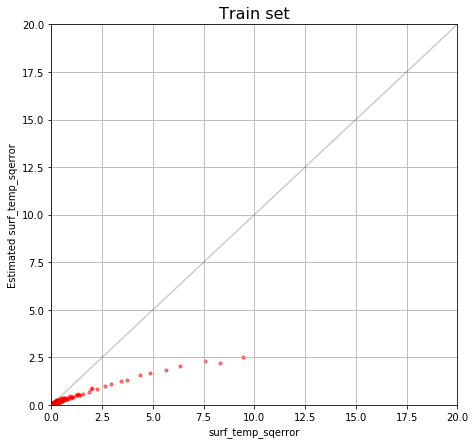

In [443]:
%matplotlib inline

from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.subplot(121)
pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
pyplot.xlim(0,20)
pyplot.ylim(0,20)
pyplot.plot(range(60), color='black', alpha=0.2)
pyplot.grid()
pyplot.title('Train set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

In [104]:
from numpy import nan, nanmean, isnan

mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std

nmean = nanmean(float_data)
where_are_NaNs = isnan(float_data)
float_data[where_are_NaNs] = 0

print(np.any(np.isnan(float_data)))
print(np.all(np.isfinite(float_data)))

False
True


In [400]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [401]:
lookback = 10
step = 2
delay = 4
batch_size = 1

In [402]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=304,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=305,
                    max_index=405,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=406,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [403]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (405 - 305 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 405 - lookback) // batch_size

print(val_steps, test_steps)

90 91


In [404]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae', metrics=['mse'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 6s 13ms/step - loss: 0.7039 - mean_squared_error: 0.7883 - val_loss: 0.6783 - val_mean_squared_error: 0.6951
Epoch 2/20
500/500 [==============================] - 4s 7ms/step - loss: 0.6068 - mean_squared_error: 0.6011 - val_loss: 0.6172 - val_mean_squared_error: 0.5992
Epoch 3/20
500/500 [==============================] - 4s 7ms/step - loss: 0.4219 - mean_squared_error: 0.3370 - val_loss: 0.5847 - val_mean_squared_error: 0.6299
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2978 - mean_squared_error: 0.2264 - val_loss: 0.5047 - val_mean_squared_error: 0.5302
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2915 - mean_squared_error: 0.2318 - val_loss: 0.4271 - val_mean_squared_error: 0.3405
Epoch 6/20
500/500 [==============================] - 4s 7ms/step - loss: 0.2620 - mean_squared_error: 0.2074 - val_loss: 0.3887 - val_mean_squared_error: 0.2914
Epoch 7/20
500/500 [=======

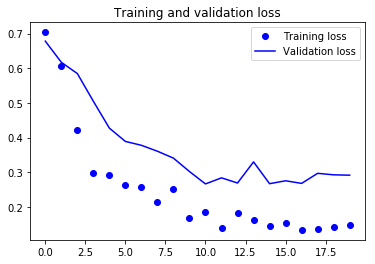

In [405]:
%matplotlib inline

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [406]:
len(df.keys())

24

In [392]:
X_train, X_test, y_train, y_test = train_test_split(rsi["data"], rsi["target"], test_size=0.2, random_state=0)

In [273]:
y_test.shape

(102,)

In [274]:
mean = X_test.mean(axis=0)
X_test -= mean
std = X_test.std(axis=0)
X_test /= std

nmean = nanmean(X_test)
where_are_NaNs = isnan(X_test)
X_test[where_are_NaNs] = 0

X_test[0]

/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


array([-0.69053945,  0.71886701,  0.85543121,  0.87743032, -0.30134159,
        0.        ,  0.        , -0.03036925, -2.48589708, -0.56428269,
       -0.30134159,  0.69870579,  0.79119199, -0.35991813,  0.93665832,
        0.        , -1.51832975, -0.18568789])

In [327]:
a = [np.zeros((224,224,3)), np.zeros((224,224,3)), np.zeros((10,224,3))]
np.array(a)
np.stack(test_gen)

ValueError: could not broadcast input array from shape (20,5,18) into shape (20)

In [418]:
preds = model.predict_generator(train_gen, 506)

In [419]:
denorm_pred = preds * std + mean

In [420]:
predsFram = pd.DataFrame(denorm_pred, columns = INDEPENDENT_FEATURES)


In [421]:
predsFram.shape

(506, 18)

In [422]:
predsFram.head(predsFram.shape[0])

,radiation,shade,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,air_temp,dew_point,surf_temp,water_amount,snow_amount,sub_temp,surf_temp_sqerror
0,443.916463,1.049403,12.716165,10.211488,0.433066,0.007572,0.007572,8.789041,101996.652053,8.162714,0.434644,12.829230,9.947033,13.757933,0.113041,0.0,8.342289,1.027207
1,420.588672,1.012276,12.486996,9.945280,0.398536,0.006876,0.006876,8.552221,101935.554392,7.917880,0.399999,12.556731,9.668983,13.420570,0.106518,0.0,8.156568,0.950971
2,418.192792,1.008463,12.463459,9.917939,0.394990,0.006805,0.006805,8.527899,101929.279357,7.892734,0.396441,12.528744,9.640426,13.385921,0.105849,0.0,8.137494,0.943141
3,400.059525,0.979604,12.285320,9.711009,0.368149,0.006264,0.006264,8.343813,101881.786639,7.702419,0.369510,12.316924,9.424290,13.123681,0.100778,0.0,7.993128,0.883881
4,468.255170,1.088139,12.955266,10.489233,0.469092,0.008297,0.008297,9.036123,102060.397400,8.418159,0.470790,13.113538,10.237133,14.109916,0.119847,0.0,8.536058,1.106747
5,448.836364,1.057233,12.764498,10.267633,0.440348,0.007718,0.007718,8.838987,102009.537735,8.214351,0.441950,12.886701,10.005675,13.829084,0.114417,0.0,8.381458,1.043286
6,-280.016609,-0.102750,5.604337,1.950223,-0.638503,-0.014006,-0.014006,1.439801,100100.603735,0.564756,-0.640491,4.372748,1.318271,3.288525,-0.089383,0.0,2.578799,-1.338633
7,423.079880,1.016241,12.511469,9.973709,0.402223,0.006950,0.006950,8.577512,101942.079097,7.944026,0.403699,12.585832,9.698676,13.456598,0.107215,0.0,8.176402,0.959113
8,-210.269649,0.008253,6.289523,2.746150,-0.535264,-0.011927,-0.011927,2.147859,100283.277539,1.296778,-0.536908,5.187483,2.149604,4.297195,-0.069880,0.0,3.134080,-1.110697
9,454.328283,1.065974,12.818450,10.330304,0.448477,0.007882,0.007882,8.894740,102023.921582,8.271990,0.450107,12.950854,10.071135,13.908507,0.115953,0.0,8.425181,1.061234


In [423]:
model.evaluate_generator(train_gen, 506)

[0.1394102250634446, 0.08961459357643899]

In [424]:
df['surf_temp_sqerror'][:91].shape

(91,)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

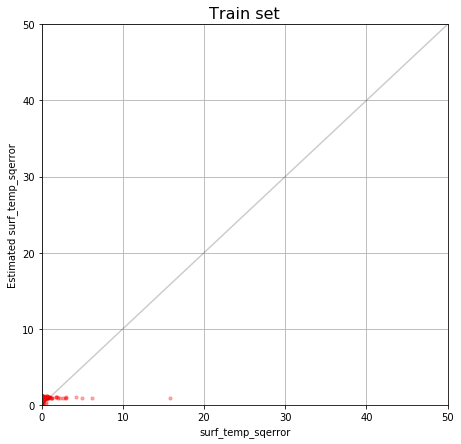

In [425]:
%matplotlib inline

from matplotlib import pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.subplot(121)
pyplot.scatter(df['surf_temp_sqerror'], predsFram['surf_temp_sqerror'], color="red", alpha=0.3, s=10)
pyplot.xlim(0,50)
pyplot.ylim(0,50)
pyplot.plot(range(60), color='black', alpha=0.2)
pyplot.grid()
pyplot.title('Train set', fontsize=16)
pyplot.xlabel('surf_temp_sqerror')
pyplot.ylabel('Estimated surf_temp_sqerror')

In [162]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

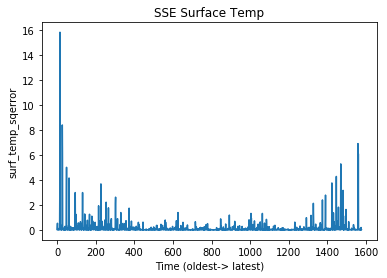

(1577, 2)


In [361]:
%matplotlib inline

import matplotlib.pyplot as plt

input_feature= df.loc[included, ['stn_surf_temp','surf_temp_sqerror']].values
input_data = input_feature

plot_data = input_feature= df.loc[included, INDEPENDENT_FEATURES + ['surf_temp_sqerror']].values
plt.plot(input_feature[:,-1])
plt.title("SSE Surface Temp")
plt.xlabel("Time (oldest-> latest)")
plt.ylabel("surf_temp_sqerror")
plt.show()

print(input_data.shape)

In [365]:
from sklearn.preprocessing import MinMaxScaler

sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:2])
print(input_data.shape)

(1577, 2)


In [366]:
lookback= 50

test_size=int(.3 * len(input_feature))
X=[]
y=[]
for i in range(len(df)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])
    
print(len(X))
print(len(y))

1526
1526


In [367]:
X, y= np.array(X), np.array(y)
X_test = X[:test_size+lookback]
X = X.reshape(X.shape[0],lookback, 2)
X_test = X_test.reshape(X_test.shape[0],lookback, 2)
print(X.shape)
print(X_test.shape)

(1526, 50, 2)
(523, 50, 2)


In [368]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [378]:
predicted_value= model.predict(X_test)
predicted_value.shape

(523, 1)

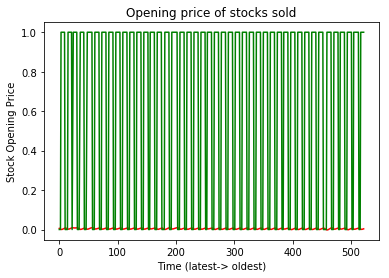

In [377]:
%matplotlib inline

plt.plot(predicted_value, color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [281]:
dataset = read_csv('station1419_forecast1.csv', header=0, infer_datetime_format=True, parse_dates=['Date Time'], index_col=['Date Time'])
dataset.head()

,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,station_id,...,air_temp,dew_point,water_amount,snow_sum,forecast_length,stn_surf_temp,stn_dew_point,radiation,shade,surf_temp_sqerror
Date Time,,,,,,,,,,,,,,,,,,,,,
2018-09-29 05:00:00,11.5,6.227035,0.0,-0.0,0.0,7.5,102250.0,6.0,0.0,1419,...,10.8,6.4,0.0,0.0,1,8.6,6.73,186.336411,1.0,0.032400
2018-09-29 07:00:00,11.8,6.720361,0.0,-0.0,0.0,7.5,102240.0,7.0,0.0,1419,...,12.9,7.4,0.0,0.0,1,11.5,7.71,675.255920,0.0,0.336400
2018-09-29 09:00:00,11.8,7.519279,0.0,-0.0,0.0,10.4,102180.0,8.0,0.0,1419,...,11.8,8.2,0.0,0.0,1,15.0,8.20,790.310791,0.0,0.532899
2018-09-29 11:00:00,12.3,6.993432,0.0,-0.0,0.0,10.6,102030.0,8.0,0.0,1419,...,12.6,7.0,0.0,0.0,1,17.5,7.99,791.719482,0.0,0.025600
2018-09-29 13:00:00,12.8,6.393786,0.0,-0.0,0.0,10.3,101870.0,8.0,0.0,1419,...,12.6,7.0,0.0,0.0,1,15.2,8.35,681.629700,0.0,0.115600


In [334]:
df.loc[included, INDEPENDENT_FEATURES + ['surf_temp_sqerror']].head()

,radiation,shade,AirTemp,DewPoint,RainPrecip,SnowPrecip,SnowPrecipAccumulated,WindSpeed,AirPressure,OctalCloudCoverage,PrecipAmount,air_temp,dew_point,surf_temp,water_amount,snow_amount,sub_temp,surf_temp_sqerror
Date Time,,,,,,,,,,,,,,,,,,
09/29/2018 05:00:00,186.336411,1.0,11.5,6.227035,0.0,-0.0,0.0,7.5,102250.0,6.0,0.0,10.8,6.4,8.78,0.0,0.0,5.88,0.032400
09/29/2018 07:00:00,675.255920,0.0,11.8,6.720361,0.0,-0.0,0.0,7.5,102240.0,7.0,0.0,12.9,7.4,12.08,0.0,0.0,9.54,0.336400
09/29/2018 09:00:00,790.310791,0.0,11.8,7.519279,0.0,-0.0,0.0,10.4,102180.0,8.0,0.0,11.8,8.2,14.27,0.0,0.0,8.26,0.532899
09/29/2018 11:00:00,791.719482,0.0,12.3,6.993432,0.0,-0.0,0.0,10.6,102030.0,8.0,0.0,12.6,7.0,17.66,0.0,0.0,6.58,0.025600
09/29/2018 13:00:00,681.629700,0.0,12.8,6.393786,0.0,-0.0,0.0,10.3,101870.0,8.0,0.0,12.6,7.0,15.54,0.0,0.0,4.41,0.115600


In [446]:
originalDf.to_csv('station_data.csv')

AttributeError: 'dict' object has no attribute 'to_csv'

In [448]:
csvDf = pd.DataFrame.from_dict(originalDf, orient="index")


In [449]:
csvDf.to_csv('station_data.csv')

In [460]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("data/data_{}.csv".format(str(key)))

    with open("data/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

In [461]:
saver(originalDf)

In [462]:
len(originalDf[(1419, 1)])

3143